# POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

In [2]:
# reading the Treebank tagged sentences with universal tagset
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data [:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
#set the random seed
random.seed(1234)


#Divide the data into training and test sets
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=1234)

#Get the length of training and test sets
print(len(train_set))
print(len(test_set))

3718
196


In [5]:
# Getting list of tagged words in training set
train_tagged_words = [tup for sent in train_set for tup in sent]
#Get the length of the total tagged words in training set
len(train_tagged_words)

95799

In [6]:
# View the first 10 tokens/words in the training set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['This',
 'year',
 ',',
 'the',
 'average',
 'of',
 'daily',
 'contracts',
 'traded',
 '*']

In [7]:
# Get the total unique words in the training set
V = set(tokens)

print(len(V))

12073


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])

len(T)

12

In [9]:
print(T)

{'CONJ', 'ADV', 'PRON', 'ADJ', '.', 'X', 'NOUN', 'PRT', 'DET', 'VERB', 'NUM', 'ADP'}


### POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


In [10]:
# Create numpy array of no of pos tags by total vocabulary
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

### Emission Probabilities

In [11]:
# compute word given tag
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1)

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
tags_matrix

array([[4.66417900e-04, 5.59701510e-02, 5.73694035e-02, 1.18936568e-01,
        3.31156701e-02, 8.86194035e-03, 3.48880589e-01, 5.13059692e-03,
        1.18470147e-01, 1.58582091e-01, 4.15111929e-02, 5.27052246e-02],
       [6.88073412e-03, 8.12581927e-02, 1.53997382e-02, 1.29750982e-01,
        1.34665787e-01, 2.32634339e-02, 3.11271306e-02, 1.47444298e-02,
        6.84796870e-02, 3.44364345e-01, 3.14547829e-02, 1.18610747e-01],
       [4.58190171e-03, 3.28369625e-02, 7.63650239e-03, 7.36922473e-02,
        4.04734649e-02, 9.39289778e-02, 2.07331046e-01, 1.18365791e-02,
        9.16380342e-03, 4.87972498e-01, 7.25467736e-03, 2.32913326e-02],
       [1.66584197e-02, 4.94804559e-03, 6.59739424e-04, 6.53142035e-02,
        6.58090040e-02, 2.14415304e-02, 6.98499084e-01, 1.08857006e-02,
        4.94804559e-03, 1.22051788e-02, 2.11116616e-02, 7.75193796e-02],
       [5.77717870e-02, 5.19317165e-02, 6.57681972e-02, 4.46540862e-02,
        9.40700844e-02, 2.73135677e-02, 2.23090753e-01, 2.33

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,CONJ,ADV,PRON,ADJ,.,X,NOUN,PRT,DET,VERB,NUM,ADP
CONJ,0.000466,0.055970,0.057369,0.118937,0.033116,0.008862,0.348881,0.005131,0.118470,0.158582,0.041511,0.052705
ADV,0.006881,0.081258,0.015400,0.129751,0.134666,0.023263,0.031127,0.014744,0.068480,0.344364,0.031455,0.118611
PRON,0.004582,0.032837,0.007637,0.073692,0.040473,0.093929,0.207331,0.011837,0.009164,0.487972,0.007255,0.023291
ADJ,0.016658,0.004948,0.000660,0.065314,0.065809,0.021442,0.698499,0.010886,0.004948,0.012205,0.021112,0.077519
.,0.057772,0.051932,0.065768,0.044654,0.094070,0.027314,0.223091,0.002336,0.173226,0.088769,0.080593,0.090386
X,0.010759,0.026108,0.056329,0.016456,0.162816,0.074842,0.062184,0.184652,0.054114,0.204114,0.002690,0.144937
NOUN,0.042263,0.017182,0.004769,0.012231,0.239307,0.029231,0.264898,0.043974,0.013250,0.146336,0.009537,0.177023
PRT,0.002280,0.009772,0.017915,0.084039,0.041694,0.014007,0.247883,0.001954,0.099674,0.402932,0.056678,0.021173
DET,0.000484,0.012698,0.003749,0.203652,0.017777,0.046197,0.638650,0.000242,0.005442,0.039545,0.022373,0.009191
VERB,0.005577,0.083501,0.035321,0.065221,0.035167,0.217816,0.110844,0.031216,0.133617,0.167622,0.022696,0.091402


In [16]:
tags_df.loc['.', :]

CONJ    0.057772
ADV     0.051932
PRON    0.065768
ADJ     0.044654
.       0.094070
X       0.027314
NOUN    0.223091
PRT     0.002336
DET     0.173226
VERB    0.088769
NUM     0.080593
ADP     0.090386
Name: ., dtype: float32

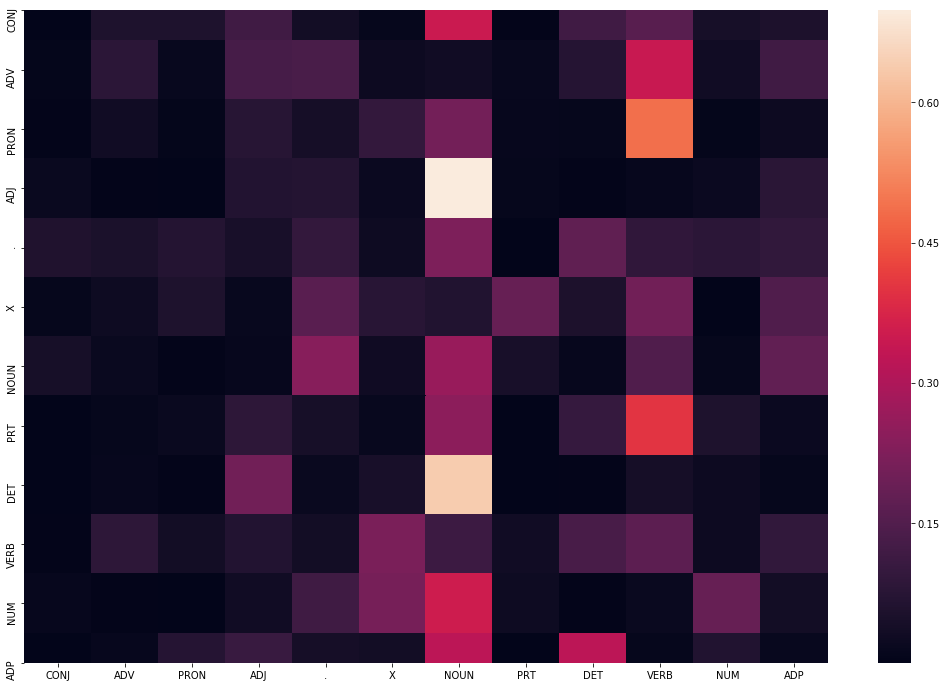

In [17]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

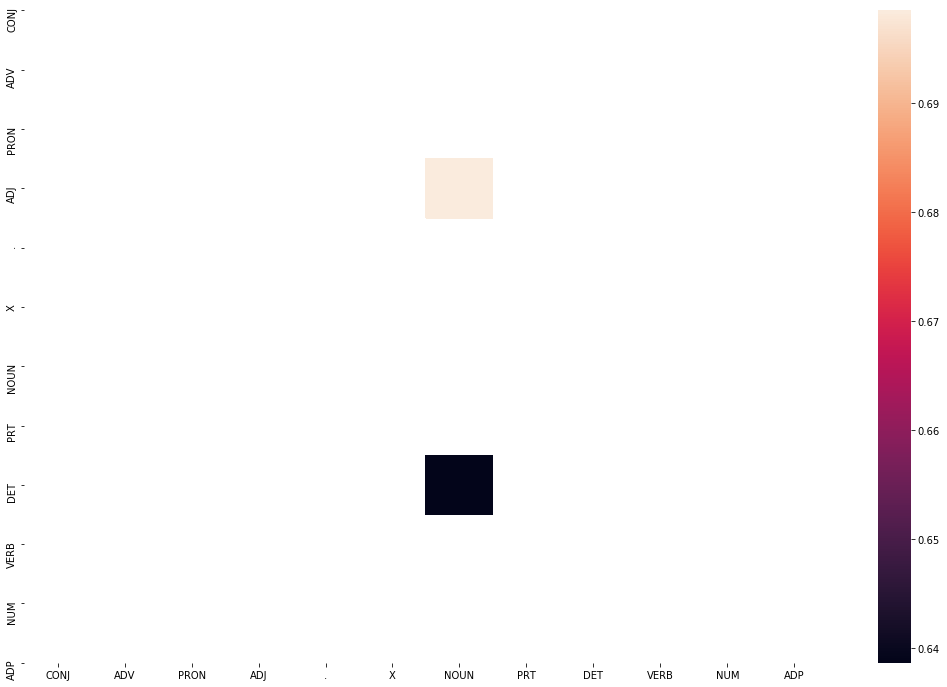

In [18]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

# Build the vanilla Viterbi based POS tagger

In [19]:
len(train_tagged_words)

95799

In [20]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [21]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)


# list of tagged words in test set
test_run_base = [tup for sent in test_set for tup in sent]

# list of  words which are untagged in test set
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [22]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [23]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  842.9450948238373
[('Ruth', 'CONJ'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', 'CONJ'), (',', '.'), ('N.C', 'NOUN'), ('.', '.'), ('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', 'CONJ'), ('trade', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Card', 'CONJ'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', 'CONJ'), ('with', 'ADP'), ('Buick',

In [24]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.906909985646914

We get ~90% of accuracy with the default Viterbi algorithm.

Let's compare with the test sentences and see how it tagged the sentences

### Reading the given Text file

In [25]:
lines=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

## Solving the problem of unknown words


In [26]:
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [27]:
#Strip the special characters and empty strings in the list file
test_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [28]:
#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('Ruth', 'CONJ'), ('Ruth', 'NOUN'))],
 [('Nelson', 'NOUN'), (('Cullowhee', 'CONJ'), ('Cullowhee', 'NOUN'))],
 [('shares', 'NOUN'), (('*T*-121', 'CONJ'), ('*T*-121', 'X'))],
 [('*T*-121', 'X'), (('trade', 'NOUN'), ('trade', 'VERB'))],
 [('.', '.'), (('Card', 'CONJ'), ('Card', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'CONJ'), ('sweepstakes', 'NOUN'))],
 [('Maxwell', 'NOUN'), (('R.D.', 'CONJ'), ('R.D.', 'NOUN'))],
 [('R.D.', 'NOUN'), (('Vos', 'CONJ'), ('Vos', 'NOUN'))],
 [(',', '.'), (('N.Y', 'CONJ'), ('N.Y', 'NOUN'))],
 [('The', 'DET'), (('Perch', 'CONJ'), ('Perch', 'NOUN'))],
 [('and', 'CONJ'), (('Dolphin', 'CONJ'), ('Dolphin', 'NOUN'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('the', 'DET'), (('Seahorse', 'CONJ'), ('Seahorse', 'NOUN'))],
 [('and', 'CONJ'), (('Tarwhine', 'CONJ'), ('Tarwhine', 'NOUN'))],
 [('be', 'VERB'), (('refunded', 'CONJ'), ('refunded', 'VERB'))],
 [('newly', 'ADV'), (('fattened', 'CONJ'), ('fattened', 'VERB'))],
 [('a', '

Most of the words which are not present in training set are simply assigned the first pos tag in the training pos tagset

Let us do the analysis on the test file which we read before



In [29]:
#Get the predictions on the test sentences
sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[('Android', 'CONJ'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'CONJ'),
 ('.', '.'),
 ('Android', 'CONJ'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'CONJ'),
 ('worldwide', 'CONJ'),
 ('on', 'ADP'),
 ('smartphones', 'CONJ'),
 ('since', 'ADP'),
 ('2011', 'CONJ'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'CONJ'),
 ('.', '.'),
 ('Google', 'CONJ'),
 ('and', 'CONJ'),
 ('Twitter', 'CONJ'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'CONJ'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'CONJ'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'CONJ'),
 ("'s", 'PRT'),
 ('firehose', 'CONJ'),
 ('.', '.'),
 ('Twitter', 'CONJ'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'CONJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 

For words like Android,Google,smartphones,Twitter,tweets,ICESAT-2,the first tag in the training pos tagset is given.i.DET


Let us see if these words exist in the training corpus

In [30]:
#Get the tokens in the test file
sample_words=[tokens for line in test_lines for tokens in word_tokenize(line)]

#Get the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

In [35]:
words_not_in_corpus = list(set(sample_words) - set(tokens)) 

Clearly the words like 'Google','Android','Fifa' are not present in the training set and they are all tagged default tags.

In [36]:
#Get the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'CONJ'),
 ('Google', 'CONJ'),
 ('Android', 'CONJ'),
 ('OS', 'CONJ'),
 ('worldwide', 'CONJ'),
 ('smartphones', 'CONJ'),
 ('2011', 'CONJ'),
 ('2013', 'CONJ'),
 ('Google', 'CONJ'),
 ('Twitter', 'CONJ'),
 ('2015', 'CONJ'),
 ('Google', 'CONJ'),
 ('Twitter', 'CONJ'),
 ('firehose', 'CONJ'),
 ('Twitter', 'CONJ'),
 ('online', 'CONJ'),
 ('interact', 'CONJ'),
 ('messages', 'CONJ'),
 ('tweets', 'CONJ'),
 ('domineering', 'CONJ'),
 ('personality', 'CONJ'),
 ('2018', 'CONJ'),
 ('FIFA', 'CONJ'),
 ('Cup', 'CONJ'),
 ('21st', 'CONJ'),
 ('FIFA', 'CONJ'),
 ('Cup', 'CONJ'),
 ('tournament', 'CONJ'),
 ('contested', 'CONJ'),
 ('Cup', 'CONJ'),
 ('trips', 'CONJ'),
 ('arriving', 'CONJ'),
 ('NASA', 'CONJ'),
 ('invited', 'CONJ'),
 ('ICESAT-2', 'CONJ'),
 ('Satellite', 'CONJ')]

In [37]:
#Let us see the count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts


Counter({'DET': 8269,
         'NOUN': 27471,
         '.': 11130,
         'ADP': 9387,
         'ADJ': 6063,
         'VERB': 12910,
         'X': 6320,
         'NUM': 3364,
         'CONJ': 2144,
         'ADV': 3052,
         'PRT': 3070,
         'PRON': 2619})

In [38]:
# see most common tags can in the training corpus
tag_counts.most_common(5)

[('NOUN', 27471), ('VERB', 12910), ('.', 11130), ('ADP', 9387), ('DET', 8269)]

In [39]:
#Lets see count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'CONJ': 342,
         'NOUN': 36,
         'ADV': 15,
         'ADJ': 19,
         'ADP': 17,
         'PRT': 2,
         'NUM': 3,
         'VERB': 19,
         'DET': 1})

In [40]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20712625871417506


[('traded', 'VERB'),
 ('totaled', 'VERB'),
 ('announced', 'VERB'),
 ('spurred', 'VERB'),
 ('served', 'VERB'),
 ('reached', 'VERB'),
 ('dropped', 'VERB'),
 ('reserved', 'VERB'),
 ('observed', 'VERB'),
 ('complicated', 'VERB'),
 ('increased', 'VERB'),
 ('succeeded', 'VERB'),
 ('offered', 'VERB'),
 ('offered', 'VERB'),
 ('based', 'VERB'),
 ('heightened', 'VERB'),
 ('turned', 'VERB'),
 ('expected', 'VERB'),
 ('printed', 'VERB'),
 ('recycled', 'VERB')]

Around 20% of words which end with 'ed' are verbs. Though it is 20% it is high because this is universal tagset and Verbs contain all the forms of verbs

In [41]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:20]

0.10929512006196747


[('holding', 'VERB'),
 ('buying', 'VERB'),
 ('causing', 'VERB'),
 ('stepping', 'VERB'),
 ('following', 'VERB'),
 ('leveraging', 'VERB'),
 ('owning', 'VERB'),
 ('soaring', 'VERB'),
 ('sorting', 'VERB'),
 ('signing', 'VERB'),
 ('installing', 'VERB'),
 ('moving', 'VERB'),
 ('changing', 'VERB'),
 ('according', 'VERB'),
 ('seeking', 'VERB'),
 ('sparking', 'VERB'),
 ('posing', 'VERB'),
 ('paying', 'VERB'),
 ('publishing', 'VERB'),
 ('borrowing', 'VERB')]

In [42]:
#Lets see percentage of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6063
4235
0.698499092858321


Around 70% of adjectives are followed by Nouns

In [43]:
#Lets see percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

8269
5281
0.6386503809408635


Around 63% of determinants are followed by Nouns

In [44]:
#Lets see percentage of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

3052
1051
0.3443643512450852


Around 34% of adverbs are followed by verbs



now use the EDA done above and set grammer rules for regex based tagger

## Rule-Based (Regular Expression) Tagger
Now let's build a rule-based, or regular expression based tagger. In NLTK, the RegexpTagger() can be provided with handwritten regular expression patterns, as shown below.

In the example below, we specify regexes for gerunds and past tense verbs (as seen above), 3rd singular present verb (creates, moves, makes etc.), modal verbs MD (should, would, could), possesive nouns (partner's, bank's etc.), plural nouns (banks, institutions), cardinal numbers CD and finally, if none of the above rules are applicable to a word, we tag the most frequent tag NN.

In [45]:

# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [46]:
regexp_tagger = nltk.RegexpTagger(patterns)
# help(regexp_tagger)

In [47]:
regexp_tagger.evaluate(test_set)

0.41275374205454174

## Viterbi Heuristic with rule based

In [48]:
# Viterbi Heuristic
def Viterbi_updated(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = regexp_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [49]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

1010.9327301979065


In [50]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy_rule = len(check)/len(updated_tagged_seq)
accuracy_rule


0.9516095960631535

## List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications
        

In [51]:
#Let us print the test lines with the initial Viterbi algorithm
for line in test_lines:
    print(list(Viterbi(word_tokenize(line))))
    print(list(Viterbi_updated(word_tokenize(line))))
    print("\n")
   


[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'CONJ'), ('.', '.')]
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


[('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'CONJ'), ('worldwide', 'CONJ'), ('on', 'ADP'), ('smartphones', 'CONJ'), ('since', 'ADP'), ('2011', 'CONJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'CONJ'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


[(

""Android is a mobile operating system developed by Google.""


Here 'Android', 'Google' are unknown words and are incorrectly tagged in the initial viterbi algorithm. However with the updated Viterbi algorithm 'Android' and 'Google' are correctly classified as Nouns though they are unknown words



"""Show me the cheapest round trips from Dallas to Atlanta""

Here trips changed to conj to noun

"""Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
"""

Here arriving changed to verb

"""NASA invited social media users to experience the launch of ICESAT-2 Satellite."""

Here NASA ,ICESAT-2 are changed to noun

# Modified Viterbi with probabilistic tagging

In [52]:
# Viterbi Heuristic
def Viterbi_prob(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        q=[]
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            q.append(transition_p )
            
            
        pmax = max(p)
        state_max=T[p.index(pmax)]
       
        #if probability is zero(unknownword)the use transistion probability
        if(pmax==0.0):
            pmax=max(q)
            state_max=T[q.index(pmax)]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [53]:
# tagging the test sentences with the Viterbi_prob algorithm
start = time.time()
updated_tagged_seq = Viterbi_prob(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

1180.7167999744415


In [55]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy_prob = len(check)/len(updated_tagged_seq)
accuracy_prob

0.9384867746565512

# Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [58]:
print("The accurcy of plain vetbri:",accuracy)
print("The accurcy of modified vetbri with Rule based tagging:", accuracy_rule)
print("The accurcy of modified vetbri with probabilistic tagging:",accuracy_prob)

The accurcy of plain vetbri: 0.906909985646914
The accurcy of modified vetbri with Rule based tagging: 0.9516095960631535
The accurcy of modified vetbri with probabilistic tagging: 0.9384867746565512


# List of cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [59]:
#Let us print the test lines with the initial Viterbi algorithm and modified viterbi
for line in test_lines:
    print(list(Viterbi(word_tokenize(line))))
    print(list(Viterbi_prob(word_tokenize(line))))
    print("\n")
   

[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'CONJ'), ('.', '.')]
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


[('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'CONJ'), ('worldwide', 'CONJ'), ('on', 'ADP'), ('smartphones', 'CONJ'), ('since', 'ADP'), ('2011', 'CONJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'CONJ'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]




""Android is a mobile operating system developed by Google.""

Here 'Android', 'Google' are unknown words and are incorrectly tagged in the initial viterbi algorithm. However with the updated Viterbi algorithm 'Android' and 'Google' are correctly classified as Nouns though they are unknown words

"""Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
"""

Here smartphones is correctly tagged as noun

"""Show me the cheapest round trips from Dallas to Atlanta""

Here trips changed to conj to noun

"""NASA invited social media users to experience the launch of ICESAT-2 Satellite."""

Here NASA ,ICESAT-2 are changed to noun